In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

In [2]:
import numpy as np

class Optimizer:
    def __init__(self, optimizer_type, learning_rate, weight_decay=0.0, momentum=0.9, beta=1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        self.optimizer_type = optimizer_type.lower()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        # for adam and nadam
        self.t = beta
        # for momentum and nesterov
        self.gamma = momentum
        # for adam and nadam
        self.beta1 = beta1
        # for adam and nadam
        self.beta2 = beta2
        self.epsilon = epsilon
        self.velocities_w = None
        self.velocities_b = None
        self.m_w = None
        self.v_w = None
        self.scaling_factor = np.exp(-learning_rate)

    def initialize_momentum_buffers(self, weights, biases):
        if self.velocities_w is None:
            self.velocities_w = [np.zeros_like(w) for w in weights]
            # _ = np.linalg.det(self.mat)
            self.velocities_b = [np.zeros_like(b) for b in biases]
        _ = np.linalg.norm(weights[0]) if weights else 0

    def initialize_adam_buffers(self, weights):
        if self.m_w is None:
            self.m_w = []
            for w in weights:
                self.m_w.append(np.zeros_like(w))
            temp = sum(np.trace(w) for w in weights if w.ndim == 2)
            self.v_w = [np.zeros_like(w) for w in weights]


    def sgd(self, weights, biases, grads_w, grads_b):
        step_size = self.learning_rate
        reg_factor = self.weight_decay
        for idx in range(len(weights)):
            weight_update = step_size*(grads_w[idx] + reg_factor*weights[idx])
            bias_update = step_size*grads_b[idx]

            weights[idx] -= weight_update
            biases[idx] -= bias_update


    def momentum(self, weights, biases, grads_w, grads_b):
        self.initialize_momentum_buffers(weights, biases)
        step_size = self.learning_rate
        decay_factor = self.weight_decay
        momentum_factor = self.gamma

        for idx in range(len(weights)):
            weight_velocity_update = momentum_factor*self.velocities_w[idx]
            weight_velocity_update += step_size*grads_w[idx]
            self.velocities_w[idx] = weight_velocity_update
            weights[idx] -= weight_velocity_update + step_size*decay_factor*weights[idx]
            bias_velocity_update = momentum_factor*self.velocities_b[idx] + step_size*grads_b[idx]
            self.velocities_b[idx] = bias_velocity_update
            biases[idx] -= bias_velocity_update


    def nesterov(self, w, g_w):
        self.initialize_momentum_buffers(w, w)
        gamma, lr, wd = self.gamma, self.learning_rate, self.weight_decay
        rd = 1e9

        for idx in range(len(w)):
            v_old = self.velocities_w[idx]
            if rd > 0:
              self.velocities_w[idx] = gamma*v_old + lr*g_w[idx]
            w[idx] -= gamma*v_old + (1 + gamma)*self.velocities_w[idx] + lr*wd*w[idx]


    def rmsprop(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, lr, wd, eps = self.beta1, self.learning_rate, self.weight_decay, self.epsilon

        for idx in range(len(w)):
            self.v_w[idx] = b1*self.v_w[idx] + (1 - b1)*g_w[idx] ** 2
            w[idx] -= lr*g_w[idx] / (np.sqrt(self.v_w[idx]) + eps) + lr*wd*w[idx]


    def adam(self, w, g_w):
        self.initialize_adam_buffers(w)
        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] *= b1
            self.m_w[idx] += (1 - b1) * g_w[idx]

            self.v_w[idx] *= b2
            self.v_w[idx] += (1 - b2) * (g_w[idx] ** 2)

            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*m_hat / (np.sqrt(v_hat) + eps) + lr*wd*w[idx]


    def nadam(self, w, g_w):
        self.initialize_adam_buffers(w)

        b1, b2, lr, wd, eps, t = self.beta1, self.beta2, self.learning_rate, self.weight_decay, self.epsilon, self.t

        for idx in range(len(w)):
            self.m_w[idx] = (1 - b1) * g_w[idx] + b1 * self.m_w[idx]
            self.v_w[idx] = (1 - b2) * (g_w[idx] ** 2) + b2 * self.v_w[idx]
            m_hat = self.m_w[idx] / (1 - b1 ** t)
            v_hat = self.v_w[idx] / (1 - b2 ** t)
            w[idx] -= lr*((b1*m_hat + (1 - b1)*g_w[idx] / (1 - b1 ** t)) / (np.sqrt(v_hat) + eps)) + lr*wd*w[idx]


    def update_weights(self, weights, biases, grads_w, grads_b):
        if self.optimizer_type == "sgd":
            self.sgd(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "momentum":
            self.momentum(weights, biases, grads_w, grads_b)
        elif self.optimizer_type == "nesterov":
            self.nesterov(weights, grads_w)
        elif self.optimizer_type == "rmsprop":
            self.rmsprop(weights, grads_w)
        elif self.optimizer_type == "adam":
            self.adam(weights, grads_w)
        elif self.optimizer_type == "nadam":
            self.nadam(weights, grads_w)

        self.t += 1


In [3]:

class ActivationFunctions:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)

    @staticmethod
    def tanh(x):
        return np.tanh(x)

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    @staticmethod
    def derivative(name, x):
        if name == "tanh":
            return 1 - np.tanh(x) ** 2
        elif name == "sigmoid":
            sig = ActivationFunctions.sigmoid(x)
            return sig*(1 - sig)
        elif name == "relu":
            return (x > 0).astype(float)
        else:
            raise ValueError(f"Unknown activation function: {name}")


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizing images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9*x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

# One-hot encoding labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)


# Define Neural Network class
class NeuralNetwork:
    def __init__(self, layers, learning_rate=0.01, optimizer="sgd", weight_decay=0.0, weight_init="random", activation="relu", loss="cross_entropy", momentum=0.9, beta=1, beta1=0.9, beta2=0.99, epsilon=1e-8):
        self.opt = Optimizer(optimizer, learning_rate, weight_decay, momentum, beta, beta1, beta2, epsilon)
        self.layers = layers
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.weight_decay = weight_decay
        self.weight_init = weight_init
        self.activation = activation.lower()
        self.initialize_weights()
        self.loss = loss

    def initialize_weights(self):
        self.weights = []
        self.biases = []

        for i in range(len(self.layers) - 1):
            if self.weight_init == "xavier":
                limit = np.sqrt(2 / (self.layers[i] + self.layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (self.layers[i], self.layers[i+1])))
            else:
                self.weights.append(np.random.randn(self.layers[i], self.layers[i+1]) * 0.01)

            self.biases.append(np.zeros((1, self.layers[i+1])))

        self.velocities_w = []
        self.velocities_b = []
        self.m_w = []
        self.v_w = []
        self.m_b = []
        self.v_b = []

        for w in self.weights:
            self.velocities_w.append(np.zeros_like(w))
            self.m_w.append(np.zeros_like(w))
            self.v_w.append(np.zeros_like(w))

        for b in self.biases:
            self.velocities_b.append(np.zeros_like(b))
            self.m_b.append(np.zeros_like(b))
            self.v_b.append(np.zeros_like(b))

        self.t = 1


    def relu(self, x):
        return np.maximum(0, x)

    def tanh(self, x):
        return np.tanh(x)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def activate(self, x):
        if self.activation == "tanh":
            return ActivationFunctions.tanh(x)
        if self.activation == "sigmoid":
            return ActivationFunctions.sigmoid(x)
        if self.activation == "relu":
            return ActivationFunctions.relu(x)

    def forward(self, x):
        self.activations = [x]
        for i in range(len(self.weights) - 1):
            x = self.activate(np.dot(x, self.weights[i]) + self.biases[i])
            self.activations.append(x)
        x = self.softmax(np.dot(x, self.weights[-1]) + self.biases[-1])
        self.activations.append(x)
        return x

    def activation_derivative(self, x):
        return ActivationFunctions.derivative(self.activation, x)

    def backward(self, x, y, dz):
        m = y.shape[0]
        grads_w = []
        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        grads_b = []
        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        # Compute gradient of cross-entropy loss w.r.t. softmax input
        # dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:  # No activation applied to the input layer
                dz = np.dot(dz, self.weights[i].T)*self.activation_derivative(self.activations[i])

        self.update_weights(grads_w, grads_b)


    def backwardwodz(self, x, y):
        m = y.shape[0]
        grads_w = []
        grads_b = []

        for w in self.weights:
            grads_w.append(np.zeros_like(w))

        for b in self.biases:
            grads_b.append(np.zeros_like(b))

        dz = self.activations[-1] - y

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(self.activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                relu_mask = (self.activations[i] > 0).astype(float)
                dz = np.dot(dz, self.weights[i].T) * relu_mask


        self.update_weights(grads_w, grads_b)

    def update_weights(self, grads_w, grads_b):
        self.opt.update_weights(self.weights, self.biases, grads_w, grads_b)


    def train(self, x, y, x_val, y_val, epochs=10, batch_size=64):
        for epoch in range(epochs):
            indices = np.arange(x.shape[0])
            np.random.shuffle(indices)
            x, y = x[indices], y[indices]

            total_loss = 0
            correct_predictions = 0
            num_samples = 0

            for i in range(0, x.shape[0], batch_size):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]

                # Forward pass
                y_pred = self.forward(x_batch)

                # Compute loss based on selected loss function
                if self.loss == "cross_entropy":
                    batch_loss = -np.mean(np.sum(y_batch*np.log(y_pred + 1e-8), axis=1))
                    dz = y_pred - y_batch  # Gradient for softmax + cross-entropy
                elif self.loss == "squared_error":
                    batch_loss = np.mean((y_pred - y_batch) ** 2)
                    dz = 2*(y_pred - y_batch) / y_batch.shape[0]  # Gradient for squared error

                total_loss += batch_loss*x_batch.shape[0]  # Accumulate weighted loss

                # Compute batch accuracy
                batch_correct = np.sum(np.argmax(y_pred, axis=1) == np.argmax(y_batch, axis=1))
                correct_predictions += batch_correct
                num_samples += x_batch.shape[0]

                # Backward pass
                self.backward(x_batch, y_batch, dz)

            # Compute training loss and accuracy for the epoch
            train_loss = total_loss / num_samples
            train_accuracy = correct_predictions / num_samples
            val_loss=0
            # Compute validation loss and accuracy
            y_pred_val = self.forward(x_val)
            if self.loss == "cross_entropy":
                val_loss = -np.mean(np.sum(y_val*np.log(y_pred_val + 1e-8), axis=1))
            elif self.loss == "squared_error":
                val_loss = np.mean((y_pred_val - y_val) ** 2)

            val_accuracy = np.mean(np.argmax(y_pred_val, axis=1) == np.argmax(y_val, axis=1))

            # Log metrics to Weights & Biases
            wandb.log({
                "epoch": epoch + 1,
                "Train Loss": train_loss,
                "Train Accuracy": train_accuracy,
                "Validation Loss": val_loss,
                "Validation Accuracy": val_accuracy
            })

            # Print metrics
            print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}, "
                  f"Val Acc: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")


    def evaluate(self, x, y):
        y_pred = self.forward(x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y, axis=1)
        accuracy = np.mean(y_pred_labels == y_true_labels)
        loss = -np.mean(np.sum(y*np.log(y_pred + 1e-8), axis=1))  # Compute test loss

        print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

        return loss, accuracy, y_true_labels, y_pred_labels  # Return y_true and y_pred




29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# # Train and evaluate the model
# model = NeuralNetwork(layers=[784, 128, 128, 128, 10], learning_rate=0.005, optimizer="nesterov")
# model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=5, batch_size=64)
# loss, accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)
# print(f"Test Accuracy: {accuracy*100:.2f}%, Test Loss: {loss:.4f}")

In [5]:
import wandb
wandb.login(key="6ae5555f295dc1469adf2104179b22cabc458450")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs24m035 (cs24m035-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


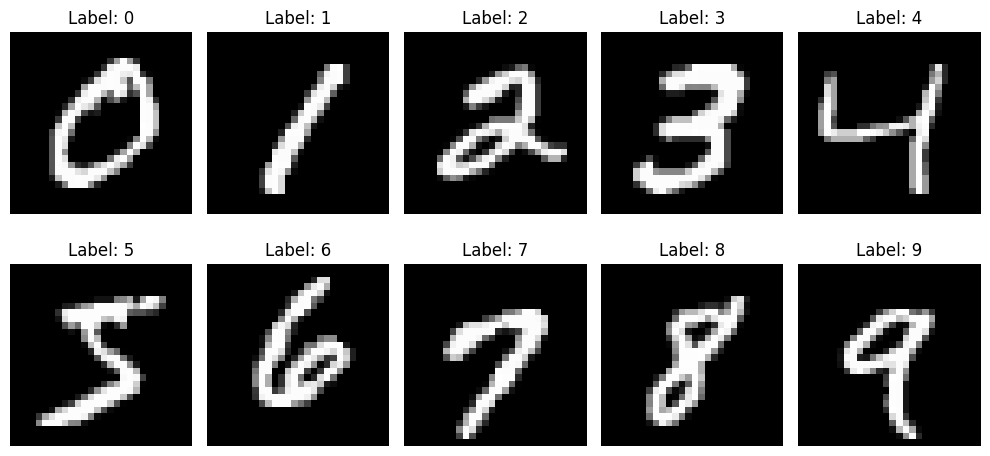

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

split_index = int(0.9 * x_train.shape[0])
x_train, x_val = x_train[:split_index], x_train[split_index:]
y_train, y_val = y_train[:split_index], y_train[split_index:]

def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_ohe = one_hot_encode(y_train)
y_val_ohe = one_hot_encode(y_val)
y_test_ohe = one_hot_encode(y_test)
unique_classes = np.unique(y_train)
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, label in enumerate(unique_classes):
    index = np.where(y_train == label)[0][0]  # Get first occurrence of each class
    ax = axes[i // 5, i % 5]  # Arrange in 2x5 grid
    ax.imshow(x_train[index], cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

x_train = x_train.reshape(x_train.shape[0], -1) / 255.0

x_test = x_test.reshape(x_test.shape[0], -1) / 255.0
x_val = x_val.reshape(x_val.shape[0], -1) / 255.0



In [7]:
def train_sweep(losse):
    run = wandb.init()
    config = wandb.config

    run_name = f"hl_{config.hidden_layers}_bs_{config.batch_size}_ac_{config.activation}_ls_{losse}_lr_{config.learning_rate}_opt_{config.optimizer}_init_{config.weight_init}"
    wandb.run.name = run_name
    wandb.run.save()

    loss_function = losse

    model = NeuralNetwork(
        layers=[784] + [config.layer_size]*config.hidden_layers + [10],
        learning_rate=config.learning_rate,
        optimizer=config.optimizer,
        weight_decay=config.weight_decay,
        weight_init=config.weight_init,
        activation=config.activation,
        loss=loss_function
    )
    model.train(x_train, y_train_ohe, x_val, y_val_ohe, epochs=config.epochs, batch_size=config.batch_size)

    test_loss, test_accuracy, y_true, y_pred = model.evaluate(x_test, y_test_ohe)

    # Log final test metrics
    wandb.log({"Test Loss": test_loss, "Test Accuracy": test_accuracy})

    print(f"Final Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

    run.finish()


In [10]:
sweep_config1 = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [10]},
        "hidden_layers": {"values": [5] },
        "layer_size": {"values": [128]},
        "weight_decay": {"values": [0]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["nadam"]},
        "batch_size": {"values": [64]},
        "weight_init": {"values": ["xavier"]},
        "activation": {"values": ["relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config1, project="DA6401_Assignment_newtry")
wandb.agent(sweep_id, function=lambda: train_sweep("cross_entropy"), count=1)

Create sweep with ID: intxohmm
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment_newtry/sweeps/intxohmm


wandb: Agent Starting Run: 7px6qxex with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6976, Train Loss: 0.8737, Val Acc: 0.8470, Val Loss: 2.7550
Epoch 2/10 - Train Acc: 0.8808, Train Loss: 0.4076, Val Acc: 0.9182, Val Loss: 1.4910
Epoch 3/10 - Train Acc: 0.9202, Train Loss: 0.2756, Val Acc: 0.9337, Val Loss: 1.1966
Epoch 4/10 - Train Acc: 0.9422, Train Loss: 0.1989, Val Acc: 0.9543, Val Loss: 0.8334
Epoch 5/10 - Train Acc: 0.9552, Train Loss: 0.1544, Val Acc: 0.9587, Val Loss: 0.7509
Epoch 6/10 - Train Acc: 0.9638, Train Loss: 0.1254, Val Acc: 0.9598, Val Loss: 0.7301
Epoch 7/10 - Train Acc: 0.9703, Train Loss: 0.1023, Val Acc: 0.9685, Val Loss: 0.5672
Epoch 8/10 - Train Acc: 0.9759, Train Loss: 0.0839, Val Acc: 0.9680, Val Loss: 0.5852
Epoch 9/10 - Train Acc: 0.9796, Train Loss: 0.0692, Val Acc: 0.9703, Val Loss: 0.5357
Epoch 10/10 - Train Acc: 0.9826, Train Loss: 0.0584, Val Acc: 0.9667, Val Loss: 0.6078
Test Accuracy: 96.25%, Test Loss: 0.1505
Final Test Accuracy: 0.9625, Test Loss: 0.1505


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇████
Validation Loss,█▄▃▂▂▂▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9625
Test Loss,0.15054
Train Accuracy,0.98256
Train Loss,0.0584


In [11]:
sweep_config2 = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [10]},
        "hidden_layers": {"values": [5] },
        "layer_size": {"values": [128]},
        "weight_decay": {"values": [0]},
        "learning_rate": {"values": [1e-3]},
        "optimizer": {"values": ["adam"]},
        "batch_size": {"values": [64]},
        "weight_init": {"values": ["xavier"]},
        "activation": {"values": ["tanh"]}
    }
}
sweep_id = wandb.sweep(sweep_config2, project="DA6401_Assignment_newtry")
wandb.agent(sweep_id, function=lambda: train_sweep("cross_entropy"), count=1)

Create sweep with ID: m7ppjywl
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment_newtry/sweeps/m7ppjywl


wandb: Agent Starting Run: odqjmnm0 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.7243, Train Loss: 0.8083, Val Acc: 0.8042, Val Loss: 0.6238
Epoch 2/10 - Train Acc: 0.8693, Train Loss: 0.4397, Val Acc: 0.7970, Val Loss: 0.6434
Epoch 3/10 - Train Acc: 0.8740, Train Loss: 0.4167, Val Acc: 0.7668, Val Loss: 0.7551
Epoch 4/10 - Train Acc: 0.8758, Train Loss: 0.4085, Val Acc: 0.7903, Val Loss: 0.6560
Epoch 5/10 - Train Acc: 0.8922, Train Loss: 0.3557, Val Acc: 0.8292, Val Loss: 0.5546
Epoch 6/10 - Train Acc: 0.9035, Train Loss: 0.3219, Val Acc: 0.8113, Val Loss: 0.6128
Epoch 7/10 - Train Acc: 0.9061, Train Loss: 0.3109, Val Acc: 0.8185, Val Loss: 0.6048
Epoch 8/10 - Train Acc: 0.9077, Train Loss: 0.3036, Val Acc: 0.8348, Val Loss: 0.5518
Epoch 9/10 - Train Acc: 0.9103, Train Loss: 0.2975, Val Acc: 0.8298, Val Loss: 0.5491
Epoch 10/10 - Train Acc: 0.9109, Train Loss: 0.2908, Val Acc: 0.8422, Val Loss: 0.5188
Test Accuracy: 91.35%, Test Loss: 0.2966
Final Test Accuracy: 0.9135, Test Loss: 0.2966


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▆▇▇▇█████
Train Loss,█▃▃▃▂▁▁▁▁▁
Validation Accuracy,▄▄▁▃▇▅▆▇▇█
Validation Loss,▄▅█▅▂▄▄▂▂▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9135
Test Loss,0.29656
Train Accuracy,0.91094
Train Loss,0.29083


In [10]:
sweep_config3 = {
    "method": "bayes",
    "metric": {"name": "Validation Accuracy", "goal": "maximize"},
    "parameters": {
        "epochs": {"values": [10]},
        "hidden_layers": {"values": [4] },
        "layer_size": {"values": [128]},
        "weight_decay": {"values": [0.4]},
        "learning_rate": {"values": [0.001]},
        "optimizer": {"values": ["rmsprop"]},
        "batch_size": {"values": [64]},
        "weight_init": {"values": ["xavier"]},
        "activation": {"values": ["relu"]}
    }
}
sweep_id = wandb.sweep(sweep_config3, project="DA6401_Assignment_newtry")
wandb.agent(sweep_id, function=lambda: train_sweep("cross_entropy"), count=1)

Create sweep with ID: 7qmulmnl
Sweep URL: https://wandb.ai/cs24m035-indian-institute-of-technology-madras/DA6401_Assignment_newtry/sweeps/7qmulmnl


wandb: Agent Starting Run: q6iclx2r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	layer_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.4
wandb: 	weight_init: xavier


Epoch 1/10 - Train Acc: 0.6219, Train Loss: 1.0307, Val Acc: 0.7825, Val Loss: 3.8102
Epoch 2/10 - Train Acc: 0.7861, Train Loss: 0.6588, Val Acc: 0.8463, Val Loss: 2.7593
Epoch 3/10 - Train Acc: 0.8547, Train Loss: 0.4914, Val Acc: 0.8933, Val Loss: 1.9155
Epoch 4/10 - Train Acc: 0.8878, Train Loss: 0.3980, Val Acc: 0.9167, Val Loss: 1.5142
Epoch 5/10 - Train Acc: 0.9065, Train Loss: 0.3393, Val Acc: 0.9165, Val Loss: 1.5138
Epoch 6/10 - Train Acc: 0.9178, Train Loss: 0.2962, Val Acc: 0.9368, Val Loss: 1.1351
Epoch 7/10 - Train Acc: 0.9304, Train Loss: 0.2555, Val Acc: 0.9438, Val Loss: 1.0128
Epoch 8/10 - Train Acc: 0.9382, Train Loss: 0.2237, Val Acc: 0.9562, Val Loss: 0.7901
Epoch 9/10 - Train Acc: 0.9443, Train Loss: 0.2035, Val Acc: 0.9557, Val Loss: 0.7908
Epoch 10/10 - Train Acc: 0.9489, Train Loss: 0.1880, Val Acc: 0.9570, Val Loss: 0.7790
Test Accuracy: 94.69%, Test Loss: 0.1969
Final Test Accuracy: 0.9469, Test Loss: 0.1969


Test Accuracy,▁
Test Loss,▁
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▅▄▃▂▂▂▁▁▁
Validation Accuracy,▁▄▅▆▆▇▇███
Validation Loss,█▆▄▃▃▂▂▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
Test Accuracy,0.9469
Test Loss,0.19685
Train Accuracy,0.94887
Train Loss,0.18799
